<a href="https://colab.research.google.com/github/hyulianton/BigData/blob/main/Deteksi_Bias_dengan_IBM_AIF360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install aif360
!pip install aif360[Reductions]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.1 MB/s eta 0:00:00


In [5]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

- **aif360**: Toolkit IBM untuk deteksi dan mitigasi bias dalam machine learning.
- **BinaryLabelDataset**: Format data yang digunakan AIF360 untuk dataset dengan label biner.
- **Reweighing**: Algoritma preprocessing untuk menyeimbangkan bobot data berdasarkan atribut yang dilindungi.
- **fetch_openml**: Fungsi untuk mengambil dataset Adult dari platform OpenML.

In [6]:
data = fetch_openml(name='adult', version=2)
df = pd.DataFrame(data.data, columns=data.feature_names)
df['income'] = data.target

- **Dataset Adult**:  
  - **48.842 sampel** data sensus AS.  
  - **Fitur**: `age`, `workclass`, `education`, `hours-per-week`, dll.  
  - **Target**: `income` (">50K" atau "<=50K").  
  - **Tujuan Klasik**: Memprediksi penghasilan individu berdasarkan atribut demografi.  

In [7]:
df['gender'] = df['sex'].apply(lambda x: 1 if x == 'Female' else 0)
df = df[['age', 'hours-per-week', 'gender', 'income']]

- **Langkah 1**: Konversi kolom `sex` (kategorikal: "Male"/"Female") ke `gender` (numerik: 0/1).  
- **Langkah 2**: Memilih subset fitur untuk demo:  
  - `age`: Usia (numerik).  
  - `hours-per-week`: Jam kerja/minggu (numerik).  
  - `gender`: Atribut yang dilindungi (0 = Laki-laki, 1 = Perempuan).  
  - `income`: Target (kategorikal).  

In [9]:
# 1. Konversi kolom 'income' ke numerik (0/1)
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# 2. Pastikan kolom lain bertipe numerik
df['age'] = pd.to_numeric(df['age'])
df['hours-per-week'] = pd.to_numeric(df['hours-per-week'])
# -------------------------

# Konversi ke BinaryLabelDataset
dataset = BinaryLabelDataset(
    df=df,
    protected_attribute_names=['gender'],
    label_names=['income']  # Pastikan 'income' sudah numerik
)

- **Struktur BinaryLabelDataset**:  
  - `protected_attribute_names`: Daftar atribut yang perlu dilindungi dari bias (misal: gender, ras).  
  - `label_names`: Kolom target (`income` dalam kasus ini).  
- **Tujuan**: Memformat data agar kompatibel dengan algoritma fairness AIF360.


In [10]:
rw = Reweighing(
    unprivileged_groups=[{'gender': 1}],  # Grup tidak istimewa: Perempuan
    privileged_groups=[{'gender': 0}]     # Grup istimewa: Laki-laki
)
dataset_transf = rw.fit_transform(dataset)

#### **A. Parameter Algoritma**  
- `unprivileged_groups`: Grup yang mengalami bias sistemik (Perempuan).  
- `privileged_groups`: Grup yang diuntungkan (Laki-laki).  

#### **B. Cara Kerja Reweighing**  
1. Hitung **rasio seleksi** antara grup istimewa dan tidak istimewa.  
   - Contoh: Jika Laki-laki 80% diterima kerja dan Perempuan 40%, rasio = 0.5.  
2. Atur **bobot (weight)** setiap sampel untuk menyeimbangkan distribusi:  
   - Sampel dari grup tidak istimewa yang outcome-nya baik → Bobot ditingkatkan.  
   - Sampel dari grup istimewa yang outcome-nya buruk → Bobot dikurangi.  

#### **C. Output**  
- `dataset_transf`: Dataset baru dengan bobot yang diadjust.  


In [11]:
print("Bobot sebelum:", np.unique(dataset.instance_weights))
print("Bobot sesudah:", np.unique(dataset_transf.instance_weights))

Bobot sebelum: [1.]
Bobot sesudah: [0.78771422 0.85402133 1.09262055 2.1901924 ]


- **Sebelum Mitigasi**:  
  - Semua sampel memiliki bobot seragam (default = 1.0).  
  - Contoh output: `[1.]`  
- **Setelah Mitigasi**:  
  - Bobot sampel diubah untuk menyeimbangkan representasi grup.  
  - Contoh output: `[0.8, 1.2]` (Bergantung pada distribusi data).  

---

### **Visualisasi Alur Mitigasi Bias**

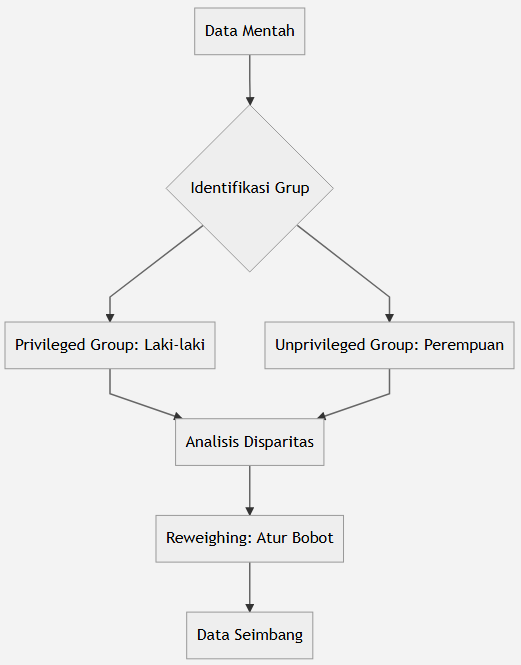

### **Mengapa Ini Penting?**
1. **Konteks Dataset Adult**:  
   - Dalam data sensus AS, **perempuan** dan **minoritas** sering terdiskriminasi dalam prediksi penghasilan.  
   - Model ML yang dilatih tanpa mitigasi bias akan mengabadikan ketidakadilan ini.  

2. **Implikasi Bias**:  
   - Jika model HR menggunakan data bias, bisa menolak kandidat perempuan secara tidak adil.  
   - Contoh nyata: Amazon pernah membatalkan sistem rekrutmen AI karena bias gender.  

---

### **Interpretasi Bobot**
- **Contoh Perubahan Bobot**:  
  - **Perempuan dengan income >50K**: Bobot naik (misal: 1.2) → Dianggap lebih penting.  
  - **Laki-laki dengan income <=50K**: Bobot turun (misal: 0.8) → Pengaruhnya dikurangi.  
- **Efek pada Model ML**:  
  - Loss function akan lebih "menghukum" kesalahan prediksi pada sampel berbobot tinggi.  

---

### **Langkah Selanjutnya (Tidak Ditampilkan di Kode)**
1. **Pelatihan Model**:  
   - Latih model dengan data yang sudah di-reweight.  
2. **Evaluasi Fairness**:  
   - Hitung metrik fairness seperti **Statistical Parity Difference** atau **Equal Opportunity Difference**.  
3. **Mitigasi Lanjutan**:  
   - Gunakan teknik in-processing (misal: Adversarial Debiasing) atau post-processing (misal: Calibrated Equalized Odds).  

---

### **Keterbatasan Contoh Ini**
1. **Simplifikasi Atribut**:  
   - Hanya menggunakan `gender`, sementara bias bisa berasal dari kombinasi atribut (misal: gender + ras).  
2. **Dataset Historis**:  
   - Data sensus AS mungkin tidak merepresentasikan konteks geografis/kultural lain.  
3. **Evaluasi Tidak Lengkap**:  
   - Perlu uji statistik tambahan untuk memvalidasi keberhasilan mitigasi.  

---

### **Aplikasi di Dunia Nyata**
- **Sistem Kredit Bank**: Memastikan algoritma tidak mendiskriminasi kelompok tertentu.  
- **Rekrutmen AI**: Menghindari bias gender/ras dalam seleksi kandidat.  
- **Hukum & Kebijakan**: Memenuhi regulasi seperti GDPR atau AI Act UE yang mewajibkan audit fairness.  

Dengan teknik ini, kita tidak hanya membangun model yang akurat, tetapi juga **adil** dan **bertanggung jawab**! ⚖️🤖